## Naudojamų kodo bibliotekų įkėlimas

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter

## Naudojamo GPU pasiekiamumo tikrinimas

In [11]:
def check_for_gpu():
    devices = tf.config.list_physical_devices()
    for device in devices:
        print(device)

check_for_gpu()

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Irisų duomenų užkrovimas

In [12]:
def load_iris_data():
    # Užkraunami duomenys iš sklearn.datasets
    iris = load_iris()
    data = iris.data
    labels = iris.target

    # Normalizuojami duomenis
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    return data, labels

## SOM implementacija
Sukuriama SOM klasė, kurią galima nesunkiai keisti

In [13]:
class SelfOrganizingMap:
    def __init__(self, m, n, dim, num_epochs, alpha=None, sigma=None):
        # Inicializuojamos klasės savybės
        self.m = m  # Eilučių skaičius tinkle
        self.n = n  # Stulpelių skaičius tinkle
        self.dim = dim  # Įėjimo vektoriaus dimensija
        self.num_epochs = num_epochs  # Mokymo epochų skaičius
        self.alpha = alpha if alpha else 0.5  # Mokymosi greitis, numatytasis 0.5
        self.sigma = sigma if sigma else max(m, n) / 2.0  # Kaimynystės spindulys, numatytasis pusė tinklelio dydžio
        self.graph = tf.Graph()  # Sukuriama TensorFlow grafinė struktūra

        # Apibrėžiama TensorFlow grafiko kontekste
        with self.graph.as_default():
            # Inicializuojami neuronų svoriai atsitiktiniais skaičiais
            self.weights = tf.Variable(tf.random.normal([m * n, dim]), name='weights')
            # Vietos laikymui įėjimo duomenims ir dabartinei iteracijai
            self.input = tf.compat.v1.placeholder(tf.float32, [dim], name='input')
            self.iteration = tf.compat.v1.placeholder(tf.float32, name='iteration')

            # Apskaičiuojamas geriausias atitikmuo (BMU)
            bmu_index = self._get_bmu_index()
            bmu_loc = self._get_bmu_location(bmu_index)

            # Mokymosi greičio ir kaimynystės spindulio mažėjimo funkcijos
            learning_rate_op = self._learning_rate_decay()
            sigma_op = self._sigma_decay()

            # Apskaičiuojama kaimynystės funkcija
            neighborhood_func = tf.exp(-tf.reduce_sum(tf.square(bmu_loc - self._location_vectors()), axis=1) / (2 * tf.square(sigma_op)))

            # Mokymosi greitis dauginamas iš kaimynystės funkcijos
            learning_rate_op *= neighborhood_func

            # Svorio atnaujinimo formulė
            delta = learning_rate_op[:, tf.newaxis] * (self.input - self.weights)
            new_weights = self.weights.assign_add(delta)

            # Grupė TensorFlow operacijų svorių atnaujinimui
            self.training_op = tf.group(new_weights)

            # Inicializuojama visos TensorFlow kintamosios
            self.init_op = tf.compat.v1.global_variables_initializer()

    # Funkcija geriausiam atitikmeniui (BMU) rasti
    def _get_bmu_index(self):
        expanded_input = tf.expand_dims(self.input, 0)
        distances = tf.reduce_sum(tf.square(self.weights - expanded_input), axis=1)
        return tf.argmin(distances, axis=0)

    # Funkcija BMU vietai rasti
    def _get_bmu_location(self, bmu_index):
        bmu_index = tf.cast(bmu_index, tf.int32)
        return tf.cast(bmu_index // self.n, tf.float32), tf.cast(tf.math.floormod(bmu_index, self.n), tf.float32)

    # Funkcija visų vietos vektorių generavimui
    def _location_vectors(self):
        x = tf.cast(tf.range(self.m), tf.float32)
        y = tf.cast(tf.range(self.n), tf.float32)
        x, y = tf.meshgrid(x, y)
        return tf.stack([tf.reshape(x, [-1]), tf.reshape(y, [-1])], axis=1)

    # Mokymosi greičio mažėjimo funkcija
    def _learning_rate_decay(self):
        return self.alpha * (1 - self.iteration / self.num_epochs)

    # Kaimynystės spindulio mažėjimo funkcija
    def _sigma_decay(self):
        return self.sigma * (1 - self.iteration / self.num_epochs)

    # Funkcija tinklo mokymui
    def train(self, data):
        self.weights_history = []  # Sąrašas svorio istorijai saugoti
        with tf.compat.v1.Session(graph=self.graph) as sess:
            sess.run(self.init_op)
            for epoch in range(self.num_epochs):
                for sample in data:
                    feed_dict = {self.input: sample, self.iteration: epoch}
                    sess.run(self.training_op, feed_dict=feed_dict)
                self.weights_history.append(sess.run(self.weights))
            self.trained_weights = sess.run(self.weights)

    # Funkcija, skirta žemėlapiuoti duomenis į neuronų tinkle
    def map_vects(self, data):
        with tf.compat.v1.Session(graph=self.graph) as sess:
            sess.run(self.init_op)
            mapped = []
            for sample in data:
                bmu_idx = sess.run(self._get_bmu_index(), feed_dict={self.input: sample})
                mapped.append(divmod(bmu_idx, self.n))
        return mapped

    # Funkcija kvantizacijos klaidai apskaičiuoti
    def quantization_error(self, data):
        error = 0
        with tf.compat.v1.Session(graph=self.graph) as sess:
            sess.run(self.init_op)
            for sample in data:
                bmu_idx = sess.run(self._get_bmu_index(), feed_dict={self.input: sample})
                bmu_weight = sess.run(self.weights[bmu_idx])
                error += np.linalg.norm(sample - bmu_weight)
        return error / len(data)


## SOM neprižiūrimas mokymas

In [14]:
def train_som(data, som_size=(10, 10), num_epochs=100):
    # Gaunami SOM tinklo dydžio parametrai
    m, n = som_size
    
    print()
    '''
    Sukuriamas SOM objektas su nurodytais parametrais:
    - tinklo dydžiu (m x n)
    - įėjimo vektoriaus dimensija (data.shape[1])
    - epochų skaičiumi (num_epochs)
    - mokymosi greičiu (lr)
    - kaimynystės spinduliu (radius)
    '''
    som = SelfOrganizingMap(m, n, data.shape[1], num_epochs)
    
    # Treniruojamas SOM su pateiktais duomenimis
    som.train(data)
    
    # Gaunami ištreniruoti svoriai
    weights = som.trained_weights
    
    # Susiejami duomenų taškai su neuronais (BMU indeksai)
    bmu_indices = som.map_vects(data)
    
    # Apskaičiuojama kvantizacijos klaida
    quantization_error = som.quantization_error(data)

    # Grąžinami SOM objektas, svoriai, BMU indeksai ir kvantizacijos klaida
    return som, weights, bmu_indices, quantization_error

## SOM lentelės atvaizdavimas

In [15]:
# Funkcija SOM rezultatų atvaizdavimui
def plot_som(som, data, labels, dim, epochs):
    m, n = dim  # Nustatomi tinklo matmenys
    grid = np.zeros((som.m, som.n))  # Sukuriama tinklelio matrica
    neuron_to_data = {i: [] for i in range(som.m * som.n)}  # Sukuriamas žemėlapis neuronų duomenims saugoti
    weights = som.trained_weights  # Gaunami galutiniai treniruoti svoriai

    # Priskiriami duomenų taškai neuronams pagal BMU
    for idx, label in enumerate(labels):
        bmu_idx = np.unravel_index(np.argmin(np.linalg.norm(weights - data[idx], axis=1)), (som.m, som.n))
        grid[bmu_idx[0], bmu_idx[1]] = label + 1
        neuron_to_data[bmu_idx[0] * som.n + bmu_idx[1]].append(label + 1)

    fig, ax = plt.subplots()  # Sukuriamas paveikslas ir ašis
    cmap = ListedColormap(plt.colormaps["viridis"](np.linspace(0, 1, 4)))  # Sukuriama spalvų paletė
    im = ax.imshow(grid, cmap=cmap, origin='upper')  # Atvaizduojamas tinklelis
    ax.set_title(f"SOM ({m}x{n}) lentelė apmokyta su {epochs} epochų")  # Nustatomas pavadinimas su epochos numeriu
    cbar = fig.colorbar(im, ticks=[0, 1, 2, 3])  # Pridedama spalvų juosta su žymėmis
    cbar.ax.set_yticklabels(['', 'Setosa', 'Versicolor', 'Virginica'])  # Nustatomos spalvų juostos etiketės

    # Pridedami unikalių klasių numerių anotacijos kiekviename neurone
    for i in range(som.m):
        for j in range(som.n):
            neuron_data = neuron_to_data[i * som.n + j]
            if neuron_data:
                distinct_classes = sorted(set(neuron_data))
                text = "\n".join(map(str, distinct_classes))
                ax.text(j, i, text, ha='center', va='center', color='black', fontsize=8)  # Anotuojami unikalūs klasių numeriai

    plt.show()

# Funkcija SOM mokymo animacijos kūrimui
def create_som_gif(som, data, labels, filename="som_training.gif"):
    fig, ax = plt.subplots()  # Sukuriamas paveikslas ir ašis
    cmap = ListedColormap(plt.colormaps["viridis"](np.linspace(0, 1, 4)))  # Sukuriama spalvų paletė

    # Atnaujinimo funkcija animacijai
    def update(frame):
        ax.clear()  # Išvaloma ašis
        weights = som.weights_history[frame]
        grid = np.zeros((som.m, som.n))  # Sukuriama tinklelio matrica
        neuron_to_data = {i: [] for i in range(som.m * som.n)}  # Sukuriamas žemėlapis neuronų duomenims saugoti
        for idx, label in enumerate(labels):
            bmu_idx = np.unravel_index(np.argmin(np.linalg.norm(weights - data[idx], axis=1)), (som.m, som.n))
            grid[bmu_idx[0], bmu_idx[1]] = label + 1
            neuron_to_data[bmu_idx[0] * som.n + bmu_idx[1]].append(label + 1)
        im = ax.imshow(grid, cmap=cmap, origin='upper')  # Atvaizduojamas tinklelis
        ax.set_title(f"Epoch {frame + 1}")  # Nustatomas pavadinimas su epochos numeriu
        ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Setosa', markerfacecolor=cmap(1), markersize=10),
                           plt.Line2D([0], [0], marker='o', color='w', label='Versicolor', markerfacecolor=cmap(2), markersize=10),
                           plt.Line2D([0], [0], marker='o', color='w', label='Virginica', markerfacecolor=cmap(3), markersize=10)])  # Pridedama legenda

        # Pridedami unikalių klasių numerių anotacijos kiekviename neurone
        for i in range(som.m):
            for j in range(som.n):
                neuron_data = neuron_to_data[i * som.n + j]
                if neuron_data:
                    distinct_classes = sorted(set(neuron_data))
                    text = "\n".join(map(str, distinct_classes))
                    ax.text(j, i, text, ha='center', va='center', color='black', fontsize=8)  # Anotuojami unikalūs klasių numeriai

        return [im]  # Grąžinamas atvaizdas

    anim = FuncAnimation(fig, update, frames=len(som.weights_history), blit=True)  # Sukuriama animacija
    writer = PillowWriter(fps=5)  # Nustatomas animacijos rašytojas
    anim.save(filename, writer=writer)  # Išsaugoma animacija
    plt.close(fig)

# Kodo vykdymas

## Pradiniai duomenys

In [22]:
# Epochų skaičius
epochs = 50

# SOM lentelės dydis
dim = (5, 5)

## Atliktų skaičiavimų spausdinimas

In [23]:
data, labels = load_iris_data()
som, weights, bmu_indices, quantization_error = train_som(data, dim, epochs)

print("SOM Neuron Weights:")
print(weights)
print("\nWinning Neurons and Assigned Data Objects:")
neuron_to_data = {}
for i, bmu in enumerate(bmu_indices):
  if bmu not in neuron_to_data:
    neuron_to_data[bmu] = []
  neuron_to_data[bmu].append(i)
for neuron, data_objects in neuron_to_data.items():
  print(f"Neuron {neuron} is assigned data objects {data_objects}")

print("\nQuantization Error:")
print(quantization_error)


SOM Neuron Weights:
[[-0.5694789   1.9819765  -1.2660614  -1.2222664 ]
 [-1.1025788   1.0617476  -1.3125368  -1.216709  ]
 [-1.3822035   0.06096344 -1.3316965  -1.3229498 ]
 [-0.9219183  -1.3926746  -0.40733308 -0.37121636]
 [-0.20876792 -1.5046595   0.23013443  0.08607648]
 [-1.1060517   1.062638   -1.3141528  -1.2200007 ]
 [-0.7921243   0.7863784  -1.2815796  -1.2255881 ]
 [-0.33030823 -0.01274295 -0.3719474  -0.43255746]
 [-0.18408789 -0.48964182  0.24468379  0.13349402]
 [ 0.11463585 -0.98466015  0.7299166   0.7286708 ]
 [-1.3827823   0.06258784 -1.3317477  -1.3224865 ]
 [-0.32712686 -0.01025652 -0.3735949  -0.43525422]
 [ 0.7912963  -0.35800675  0.46135855  0.2515448 ]
 [ 0.23733625 -0.0657743   0.54606557  0.5679541 ]
 [ 0.5728915  -0.63757515  0.88008577  1.0259807 ]
 [-0.9164971  -1.3969593  -0.41405576 -0.37147254]
 [-0.18277171 -0.4909644   0.2420276   0.1256487 ]
 [ 0.23598167 -0.06200249  0.5445541   0.5660035 ]
 [ 0.88945323  0.12909329  0.7159317   0.6673492 ]
 [ 1.00268

## Sukuriamas mokymosi ciklo atvaizdavimas ir paskutinės epochos SOM

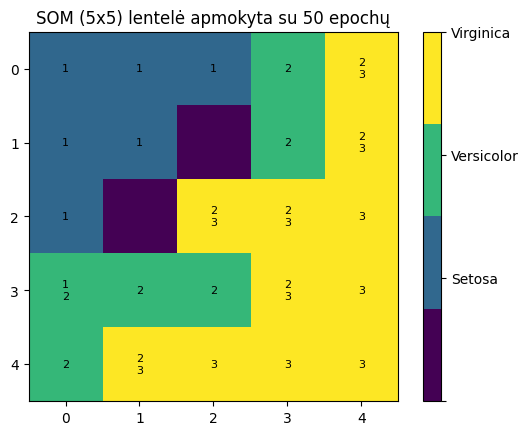

In [24]:
create_som_gif(som, data, labels, "som_training1.gif")
plot_som(som, data, labels, dim, epochs)